### Convolution Neural Network

- Implemented CNN on MNIST dataset
- Generated loss curves, accuracy
- Learning rate comparisons
- Means and Std Deviation of loss and accuracy 

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from tqdm import tqdm, trange

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F


# # moves your model to train on your gpu if available else it uses your cpu
# device = ("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define transform to normalize data
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])


# Download and load the training data
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
test_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)

In [ ]:
## Further splitting train_set into validation_set 
train_set, val_set = torch.utils.data.random_split(train_set, [50000, 10000])

## Loading the training and validation set 
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True)

In [ ]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        # Convolutional Neural Network Layer 
        
        self.convolutaional_neural_network_layers = nn.Sequential(
                # Here we are defining our 2D convolutional layers
                # We have in_channels=1 because our input is a grayscale image
                nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                # After the first convolutional layer the output of this layer is: [( 28 + 2*1 - 3)/1] + 1 = 28.  
                nn.MaxPool2d(kernel_size=2), 
                # Since we applied maxpooling with kernel_size=2 we have to divide by 2, so we get
                # 28 / 2 = 14 
                # output of our second conv layer
                nn.Conv2d(in_channels=16, out_channels=4, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                # After the second convolutional layer the output of this layer is: [(14 + 2*1 - 3)/1] + 1 = 14. 
                nn.MaxPool2d(kernel_size=2) 
                # Since we applied maxpooling with kernel_size=2 we have to divide by 2, so we get
                # 14 / 2 = 7
        )

        # Linear layer
        self.linear_layers = nn.Sequential(
                # We have the output_channel= 4 of our second conv layer, and 7*7 is derived by the formular 
                # which is the output of each convolutional layer  
                nn.Linear(in_features=7*7*4, out_features=10)
        )

    # Defining the forward pass 
    def forward(self, x):
        x = self.convolutaional_neural_network_layers(x)
        # After we get the output of our convolutional layer we must flatten it or rearrange the output into a vector
        x = x.view(x.size(0), -1)
        # Then pass it through the linear layer
        x = self.linear_layers(x)
        # The softmax function returns the prob likelihood of getting the input image. 
        # We will see a much graphical demonstration below
        #x = F.softmax(x, dim=1)
        return x

### **Model Training - Training Data** 

In [ ]:
NUM_EPOCHS = 15
model = Network()
opt = torch.optim.Adam(model.parameters(), lr =0.001)

trainloss_epoch = []
valloss_epoch = []
trainacc_epoch = []
valacc_epoch = []

trainloss_batch = []

for epoch in trange(NUM_EPOCHS):
    model.train()
    for i, (inputs, classes) in enumerate(train_loader):

        opt.zero_grad()

        y = model(inputs)
        loss = F.cross_entropy(y, classes)
        
        trainloss_batch.append(loss.item())
        
        loss.backward()
        opt.step()
    
    with torch.no_grad():

        model.eval()  
        trainloss = 0.0
        traincorrect = 0
        num = 0
        for inputs, classes in train_loader:

            y = model(inputs)
            loss = F.cross_entropy(y, classes, reduction='none')
            
            num += loss.size(0)
            trainloss += loss.sum().item()
            traincorrect += (y.argmax(dim=1) == classes).sum().item()
        
        trainloss_epoch.append(trainloss/num)
        trainacc_epoch.append(traincorrect/num)
        
        valloss = 0.0
        valcorrect = 0
        num = 0
        for inputs, classes in val_loader:

            y = model(inputs)
            loss = F.cross_entropy(y, classes, reduction='none')
            
            num += loss.size(0)
            valloss += loss.sum().item()
            valcorrect += (y.argmax(dim=1) == classes).sum().item()
        
        valloss_epoch.append(valloss/num)
        valacc_epoch.append(valcorrect/num)


100%|██████████| 15/15 [11:42<00:00, 46.83s/it]


### **Training Set and Validation Set : Loss Curve + Accuracy** 

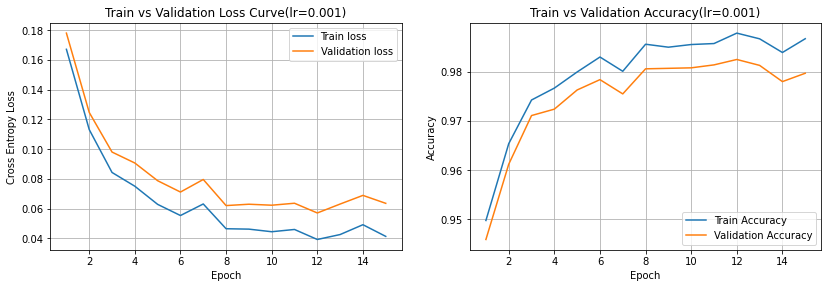

In [ ]:
epoch_count = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(12,4.5))

plt.subplot(1, 2, 1)
plt.plot(epoch_count, trainloss_epoch, label='Train loss')
plt.plot(epoch_count, valloss_epoch, label='Validation loss')
plt.legend()
plt.title("Train vs Validation Loss Curve(lr=0.001)")  
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.grid()


plt.subplot(1, 2, 2)
plt.plot(epoch_count, trainacc_epoch, label='Train Accuracy')
plt.plot(epoch_count, valacc_epoch, label='Validation Accuracy')
plt.legend()
plt.title("Train vs Validation Accuracy(lr=0.001)")  
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.grid()

plt.tight_layout(pad = 2.5)

### **Training Batch Loss** 

11730


Text(0, 0.5, 'Cross Entropy Loss')

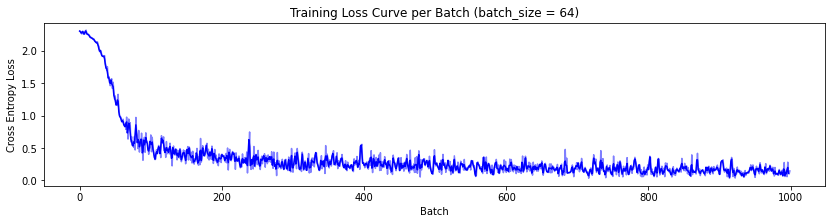

In [ ]:
print(len(trainloss_batch))
train_lb = trainloss_batch[:1000]

plt.figure(figsize=(14, 3))
plt.plot(train_lb, color='blue', alpha=0.5)

k = 2
smoothed, idx = [], []
for to in range(k, len(train_lb)):
    fr = to - k
    smoothed.append(sum(train_lb[fr:to])/k)
    idx.append(to)
    
plt.plot(smoothed, color='blue')
plt.title("Training Loss Curve per Batch (batch_size = 64)")
plt.xlabel("Batch")
plt.ylabel("Cross Entropy Loss")
#plt.xlim(0, 1000)
#clean()


## **Model Peformance on Test Set**

In [ ]:
test_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)
#print(len(test_set))

In [ ]:
model = Network()
opt = torch.optim.Adam(model.parameters(), lr =0.001)

trainloss_epoch = []
testloss_epoch = []
trainacc_epoch = []
testacc_epoch = []

for epoch in trange(NUM_EPOCHS):
    for i, (inputs, classes) in enumerate(train_loader):

        opt.zero_grad()

        y = model(inputs)
        loss = F.cross_entropy(y, classes)
      
        loss.backward()
        opt.step()
    
    with torch.no_grad():
        
        trainloss = 0.0
        traincorrect = 0
        num = 0
        for inputs, classes in train_loader:

            y = model(inputs)
            loss = F.cross_entropy(y, classes, reduction='none')
            
            num += loss.size(0)
            trainloss += loss.sum().item()
            traincorrect += (y.argmax(dim=1) == classes).sum().item()
        
        trainloss_epoch.append(trainloss/num)
        trainacc_epoch.append(traincorrect/num)
        
        testloss = 0.0
        testcorrect = 0
        num = 0
        for inputs, classes in test_loader:

            y = model(inputs)
            loss = F.cross_entropy(y, classes, reduction='none')
            
            num += loss.size(0)
            testloss += loss.sum().item()
            testcorrect += (y.argmax(dim=1) == classes).sum().item()
        
        testloss_epoch.append(testloss/num)
        testacc_epoch.append(testcorrect/num)



  0%|          | 0/15 [00:00<?, ?it/s]

  7%|▋         | 1/15 [00:45<10:43, 45.95s/it]

 13%|█▎        | 2/15 [01:31<09:56, 45.86s/it]

 20%|██        | 3/15 [02:17<09:10, 45.84s/it]

 27%|██▋       | 4/15 [03:05<08:32, 46.55s/it]

 33%|███▎      | 5/15 [03:51<07:43, 46.37s/it]

 40%|████      | 6/15 [04:41<07:06, 47.42s/it]

 47%|████▋     | 7/15 [05:27<06:16, 47.03s/it]

 53%|█████▎    | 8/15 [06:13<05:27, 46.76s/it]

 60%|██████    | 9/15 [06:59<04:39, 46.54s/it]

 67%|██████▋   | 10/15 [07:45<03:51, 46.32s/it]

 73%|███████▎  | 11/15 [08:31<03:05, 46.36s/it]

 80%|████████  | 12/15 [09:17<02:18, 46.21s/it]

 87%|████████▋ | 13/15 [10:03<01:32, 46.02s/it]

 93%|█████████▎| 14/15 [10:48<00:45, 45.80s/it]

100%|██████████| 15/15 [11:33<00:00, 46.26s/it]


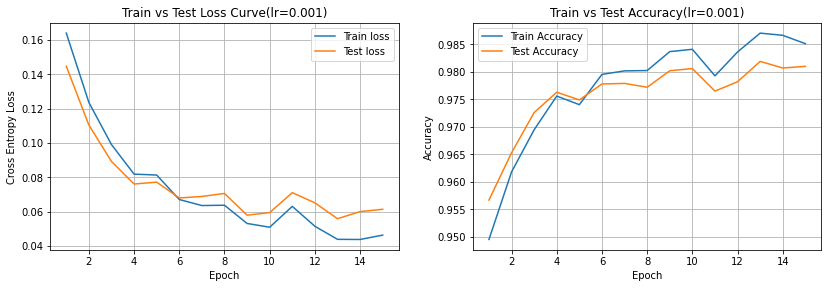

In [ ]:
epoch_count = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(12,4.5))

plt.subplot(1, 2, 1)
plt.plot(epoch_count, trainloss_epoch, label='Train loss')
plt.plot(epoch_count, testloss_epoch, label='Test loss')
plt.legend()
plt.title("Train vs Test Loss Curve(lr=0.001)")  
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.grid()


plt.subplot(1, 2, 2)
plt.plot(epoch_count, trainacc_epoch, label='Train Accuracy')
plt.plot(epoch_count, testacc_epoch, label='Test Accuracy')
plt.legend()
plt.title("Train vs Test Accuracy(lr=0.001)")  
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.grid()

plt.tight_layout(pad = 2.5)

##### **Test Classification Error**

In [ ]:
def accuracy(setloader):
  correct = 0
  total = 0
  with torch.no_grad():
    for data in setloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  return (correct / total)

In [ ]:
test_class_error = accuracy(test_loader)
print(test_class_error)
print(f"The test classification error of the network is :{(1 - test_class_error)}")

0.981
The test classification error of the network is :0.019000000000000017



###**ADAM optimizer with different step sizes***

In [ ]:
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
# Split into train and validation
train_set, val_set = torch.utils.data.random_split(train_set, [50000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle = True)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

curves = {}

for lr in tqdm([0.01, 0.001, 0.0001, 0.00000001]):

  model = Network()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  curve = []

  for epoch in range(2):
    for idx, (images, labels) in enumerate(val_loader): 

            # Training pass
            optimizer.zero_grad()

            # Forward pass
            output = model(images)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(output, labels)

            curve.append(loss.item())

            #Backward pass
            loss.backward()
            optimizer.step()
            
            
    curves[lr] = curve



  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:51<02:34, 51.43s/it]

 50%|█████     | 2/4 [01:42<01:42, 51.36s/it]

 75%|███████▌  | 3/4 [02:35<00:51, 51.81s/it]

100%|██████████| 4/4 [03:26<00:00, 51.59s/it]


Text(0.5, 1.0, 'Peformance of Adam Optimizer with different step sizes (batch_size=64, validation set)')

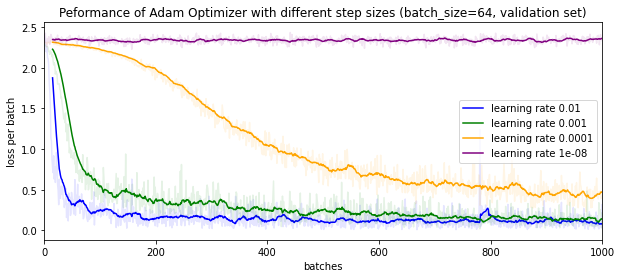

In [ ]:
plt.figure(figsize=(10, 4))

for (lr, curve), color in zip(curves.items(), ['blue', 'green', 'orange', 'purple']):
  plt.plot(curve, color=color, alpha=0.1)

  k = 15
  smoothed, idx = [], []
  for to in range(k, len(curve)):
    fr = to - k
    smoothed.append(sum(curve[fr:to])/k)
    idx.append(to)

  plt.plot(idx, smoothed, color=color, label=f'learning rate {lr}')

plt.xlim(0, 1000)
plt.legend()

plt.xlabel('batches')
plt.ylabel('loss per batch')
plt.title("Peformance of Adam Optimizer with different step sizes (batch_size=64, validation set)")

#clean()

### **Adam Optimizer (Std Deviation and Mean of Loss per Batch)**

In [ ]:
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
# Split into train and validation
train_set, val_set = torch.utils.data.random_split(train_set, [50000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True)

In [ ]:
def adam_deviation(setloader, NUM_EPOCHS, lr):

  #model = Network()
  criterion = nn.CrossEntropyLoss()

  ## Defining the Adam optimizer for the model
  optimizer = optim.Adam(model.parameters(), lr)
  
  set_losses = []
  set_acc = []
  #loss_batch = []

  for epoch in range(NUM_EPOCHS):
      # prep model for training
     
      running_loss = 0
      for idx, (images, labels) in enumerate(setloader): 

          # Training pass
          optimizer.zero_grad()

          # Forward pass
          output = model(images)
          loss = criterion(output, labels)
          running_loss += loss.item()
          #loss_batch.append(loss.item())

          #Backward pass
          loss.backward()
          optimizer.step()
    
      set_losses.append(running_loss/len(setloader))
      running_accuracy = accuracy(setloader)
      set_acc.append(running_accuracy)

      print("Epoch: {}/{}  ".format(epoch+1, NUM_EPOCHS),  
            "Loss: {:.4f}  ".format(running_loss/len(setloader)),
            "Accuracy : {}".format(100* running_accuracy)
                )

  print("Finished Training") 
  #print(len(loss_batch))

  return set_losses, set_acc

In [ ]:
#Parameters
model = Network()
NUM_EPOCHS = 15
lr = 0.001

# Checking on validation set
print("Validation Set")
val_loss_1, val_acc_1 = adam_deviation(val_loader, NUM_EPOCHS, lr)
val_loss_2, val_acc_2 = adam_deviation(val_loader, NUM_EPOCHS, lr)
val_loss_3, val_acc_3 = adam_deviation(val_loader, NUM_EPOCHS, lr)

Validation Set
Epoch: 1/15   Loss: 1.0155   Accuracy : 85.45
Epoch: 2/15   Loss: 0.3944   Accuracy : 89.44
Epoch: 3/15   Loss: 0.3142   Accuracy : 91.96
Epoch: 4/15   Loss: 0.2489   Accuracy : 93.64
Epoch: 5/15   Loss: 0.2110   Accuracy : 94.58
Epoch: 6/15   Loss: 0.1757   Accuracy : 95.37
Epoch: 7/15   Loss: 0.1507   Accuracy : 96.32
Epoch: 8/15   Loss: 0.1313   Accuracy : 96.5
Epoch: 9/15   Loss: 0.1199   Accuracy : 96.58
Epoch: 10/15   Loss: 0.1109   Accuracy : 97.45
Epoch: 11/15   Loss: 0.0976   Accuracy : 97.27
Epoch: 12/15   Loss: 0.0927   Accuracy : 97.75
Epoch: 13/15   Loss: 0.0845   Accuracy : 97.45
Epoch: 14/15   Loss: 0.0805   Accuracy : 98.11999999999999
Epoch: 15/15   Loss: 0.0733   Accuracy : 98.00999999999999
Finished Training
Epoch: 1/15   Loss: 0.0730   Accuracy : 97.7
Epoch: 2/15   Loss: 0.0691   Accuracy : 97.72999999999999
Epoch: 3/15   Loss: 0.0623   Accuracy : 98.38
Epoch: 4/15   Loss: 0.0596   Accuracy : 98.58
Epoch: 5/15   Loss: 0.0555   Accuracy : 98.8
Epoch: 6

In [ ]:
import statistics as ss
import numpy as np

print(len(val_loss_1))

means1= list()
std_deviation1 = list()
temp = list()
for i in range(len(val_loss_1)):
    temp.append(val_loss_1[i])
    temp.append(val_loss_2[i])
    temp.append(val_loss_3[i])
    means1.append(ss.mean(temp))
    std_deviation1.append(ss.stdev(temp))
    temp = list()

means2= list()
std_deviation2 = list()
temp = list()
for i in range(len(val_acc_1)):
    temp.append(val_acc_1[i])
    temp.append(val_acc_2[i])
    temp.append(val_acc_3[i])
    means2.append(ss.mean(temp))
    std_deviation2.append(ss.stdev(temp))
    temp = list()

means1 = np.asarray(means1)
std_deviation1 = np.asarray(std_deviation1)
means2 = np.asarray(means2)
std_deviation2 = np.asarray(std_deviation2)


15


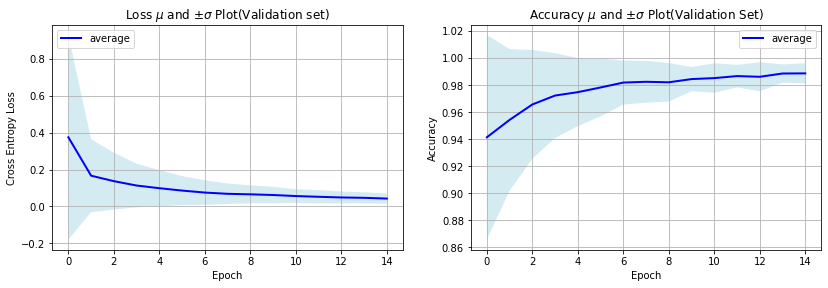

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4.5))
t = np.arange(len(means1))

ax1.plot(means1, lw=2, label='average', color='blue')
ax1.fill_between(t, means1 + std_deviation1, means1 - std_deviation1, facecolor='lightblue', alpha=0.5)
ax1.set_title(r'Loss $\mu$ and $\pm \sigma$ Plot(Validation set)')
ax1.legend(loc='upper left')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Cross Entropy Loss')
ax1.grid()



# fig, ax = plt.subplots(2)
t = np.arange(len(means2))

ax2.plot(means2, lw=2, label='average', color='blue')
ax2.fill_between(t, means2 + std_deviation2, means2 - std_deviation2, facecolor='lightblue', alpha=0.5)
ax2.set_title(r'Accuracy $\mu$ and $\pm \sigma$ Plot(Validation Set)')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid()

plt.tight_layout(pad = 2.5)
